In [25]:
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt



In [26]:
def save_dict_list_as(dic, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(dic, file)
    return 0
    

def load_dict_list(file_name):
    with open(file_name, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

features = load_dict_list("Food_group/features.pkl")

In [27]:

# {1 : [icc_feat_1,....,iccfeat_n],....., N : [icc_feat_1,....,icc_feat_n}

def plot_ICC(icc_scores, features = features, nb_day = 7, add_curve_uncons = False, var = False, icc_uncons = None):
    if add_curve_uncons == True : 
        var = True
    num_features = len(features)
    num_rows = int(math.ceil(math.sqrt(num_features)))
    num_cols = int(math.ceil(num_features / num_rows))
    fig_width = num_cols * 4
    fig_height = num_rows * 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    max_value = float('-inf')
    min_value = float('inf')
    axs = axs.ravel() 
    icc_scores[nb_day] = [1]* len(icc_scores[2])
    if add_curve_uncons : 
        icc_uncons[nb_day] = [1]* len(icc_scores[2])
    
    for i, c in enumerate(features):
        start = 1
        if var:
            start = 2
        icc_values = [icc_scores[j][i] for j in range(start,nb_day+1)]
        icc_values_uncons = [icc_uncons[j][i] for j in range(start,nb_day+1)]
        max_value = max(max_value, max(icc_values))
        min_value = min(min_value, min(icc_values))
        label = [None,None]
        if i == 0 :
            label = [ "ICC consecutive days (Mon --> Sun)", "Avg ICC non consecutive days"]
        axs[i].plot(range(start, nb_day + 1), icc_values, marker='s', label = label[0])
        if add_curve_uncons:
            
            axs[i].plot(range(2, nb_day+1), icc_values_uncons, marker='s', color="red", label=label[1])  #! ==> Need the [1,....,1] col 
        axs[i].set_title(c.replace('_', ' ').replace('eaten', ''))
        axs[i].axhline(y=0.8, linestyle='--', linewidth=0.8)
        axs[i].axhspan(0.6, 0.8, facecolor='orange', alpha=0.5)
        axs[i].axhspan(0.8, 1, facecolor='green', alpha=0.5)
        axs[i].axhline(y=0.6, linestyle='--', linewidth=0.8, color = "orange")
        axs[i].set_xticks(range(start, nb_day + 1))

    for i in range(num_features, num_rows * num_cols):
        axs[i].axis('off')
    for ax in axs[:num_features]:
        ax.set_ylim(min_value, max_value)

    fig.legend(loc='lower right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
    plt.tight_layout()
    plt.show()




In [28]:
file_mean = {
    2: "ICC_Results/unconsecutive/mean/icc_mean_uncons_2.pkl",
    3: "ICC_Results/unconsecutive/mean/icc_mean_uncons_3.pkl",
    4: "ICC_Results/unconsecutive/mean/icc_mean_uncons_4.pkl",
    5: 'ICC_Results/unconsecutive/mean/icc_mean_uncons_5.pkl',
    6: 'ICC_Results/unconsecutive/mean/icc_mean_uncons_6.pkl',
}

file_wstd = {
    2: "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_2.pkl",
    3:  "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_3.pkl",
    4: "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_4.pkl",
    5: 'ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_5.pkl',
    6: 'ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_6.pkl',
}

def extract_icc(file_name) : 
    icc_mean_tot = {}
    for day, f in file_name.items():
        icc_mean = load_dict_list(f)
        icc_mean_tot[day] = icc_mean
    return icc_mean_tot

icc_mean_tot = extract_icc(file_mean)
icc_wstd_tot = extract_icc(file_wstd)
        


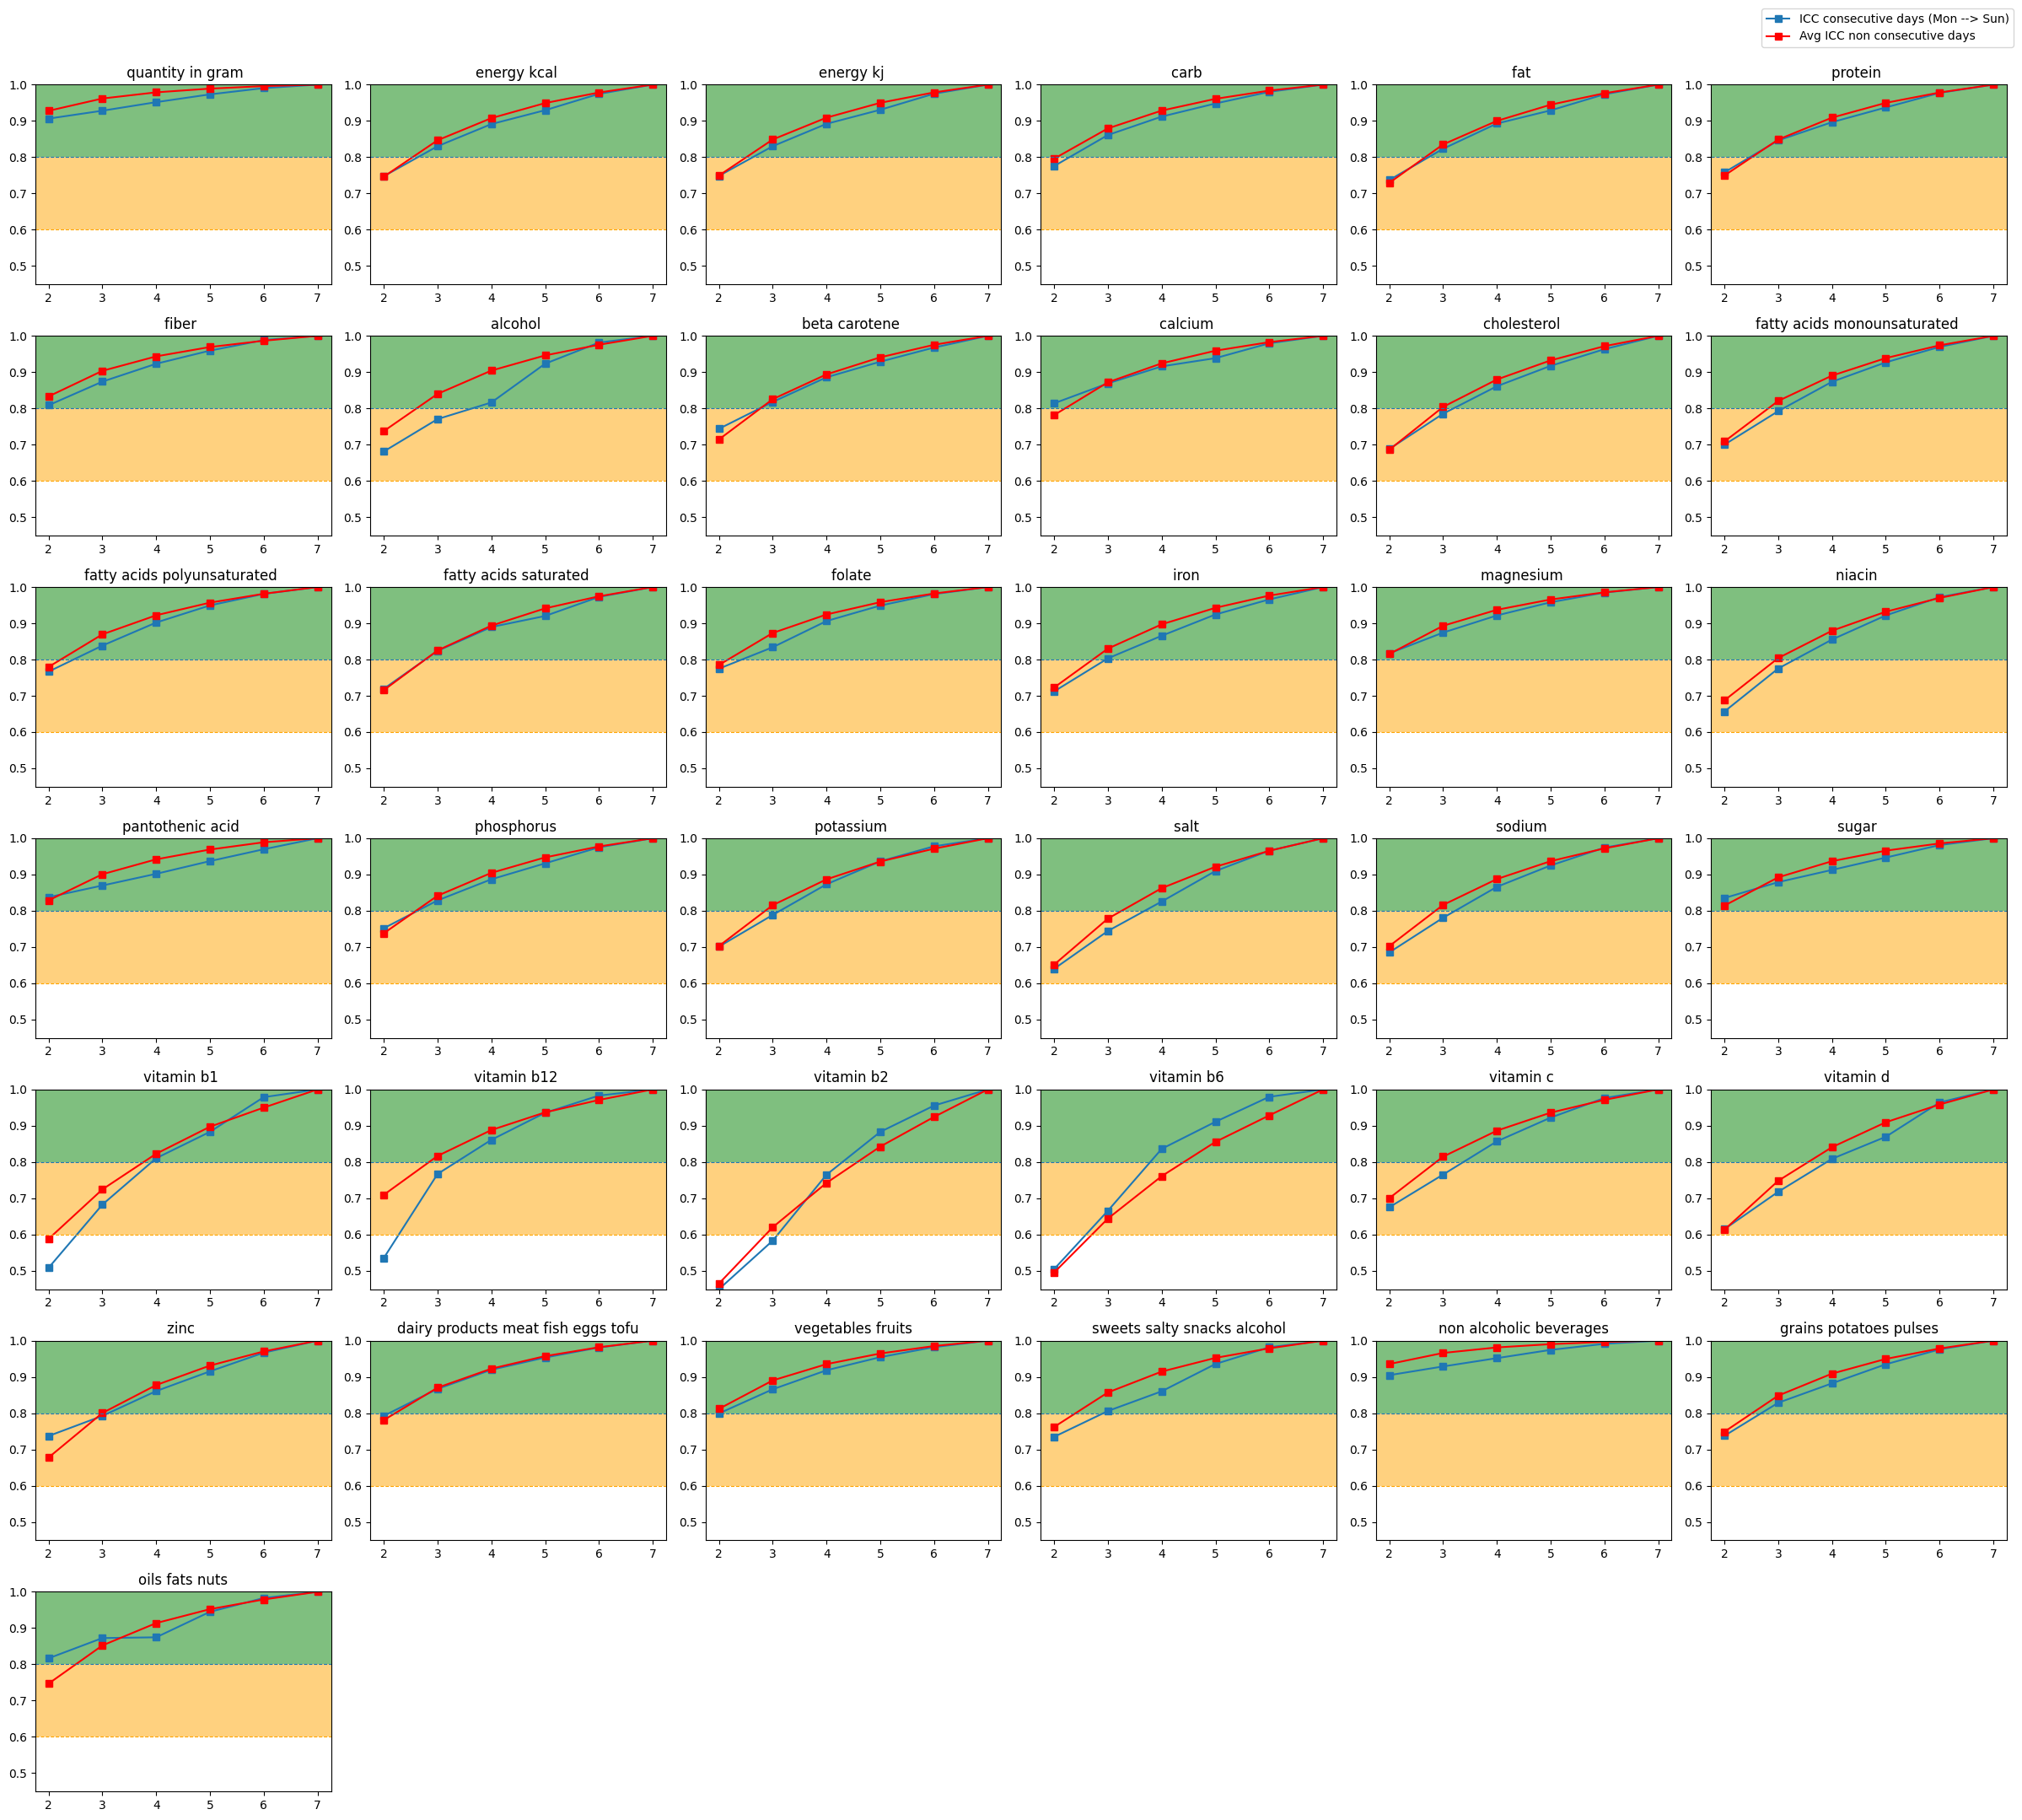

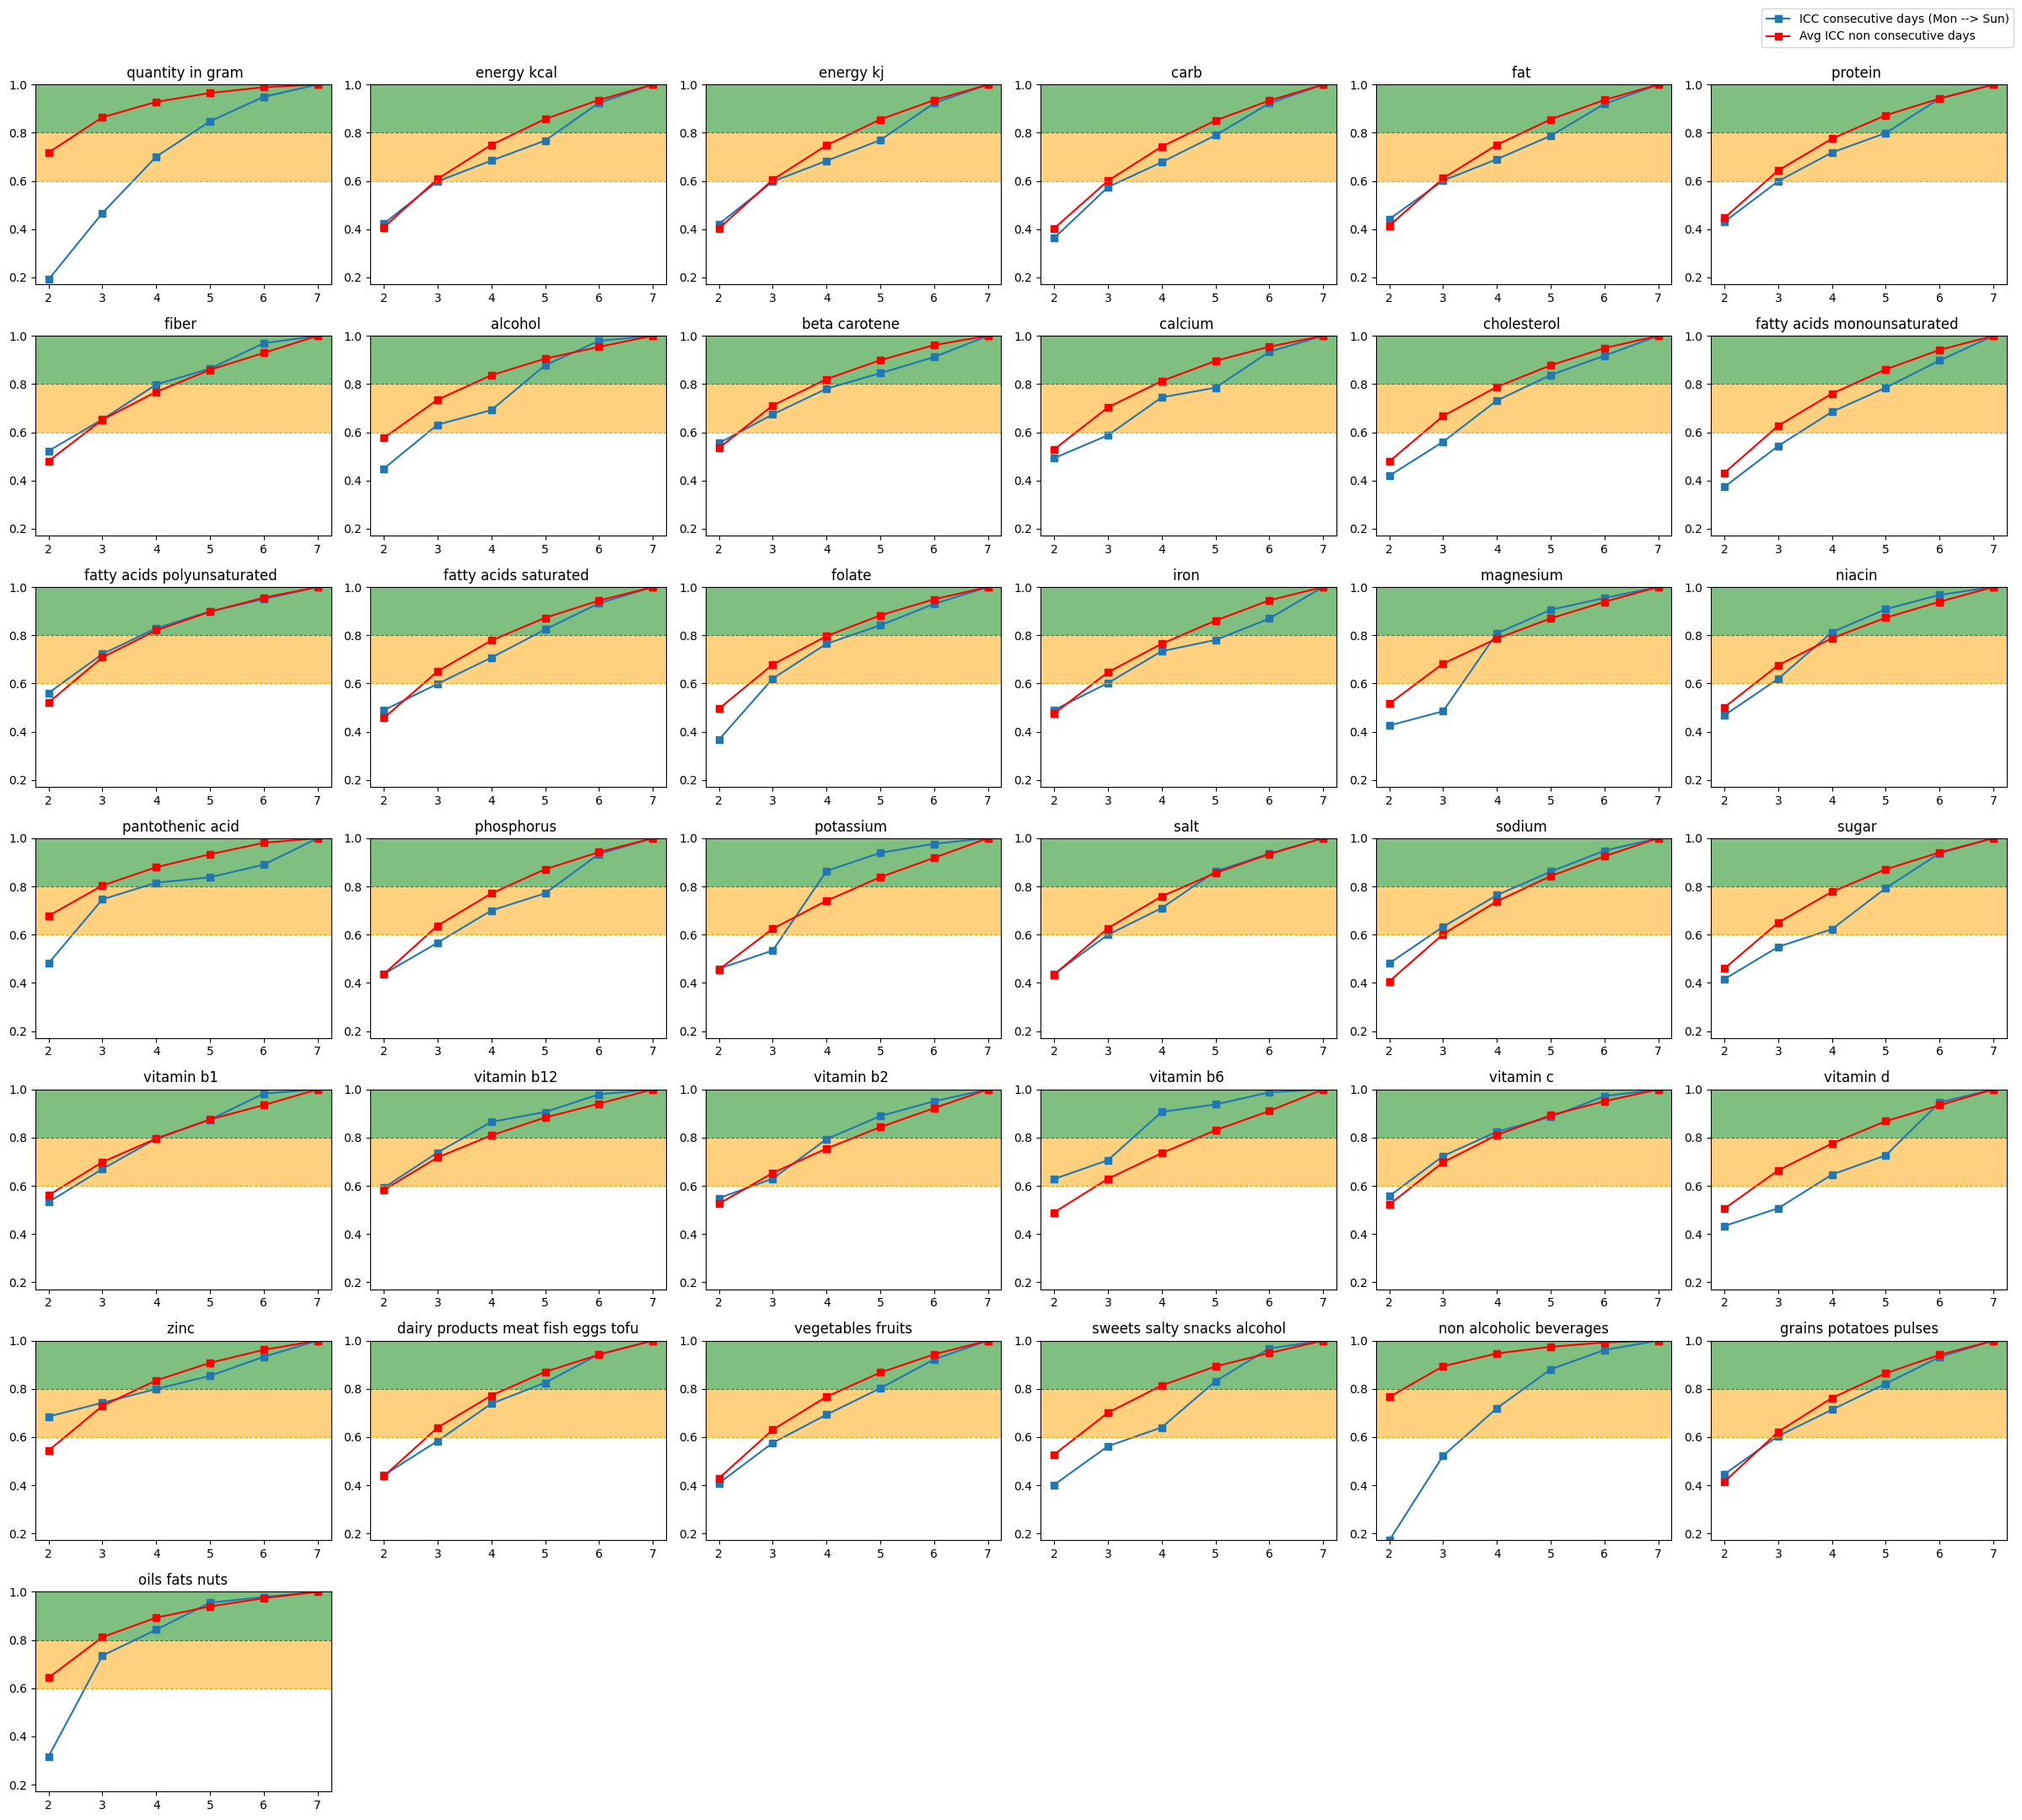

0

In [29]:

#Avg ICC score for each combinations  of same length of days
def plot_comp(icc_tot, mean = True):
    icc_avg_comb_week  ={}
    i = 2
    for d in icc_tot.values():
        nb_l = len(d)
        long_l = len(next(iter(d.values())))
        avg = [sum(valeurs[i] for valeurs in d.values()) / nb_l for i in range(long_l)]
        icc_avg_comb_week[i] = avg
        i+=1
      
    if mean :     
        icc_cons = load_dict_list("ICC_Results/consecutive/mean/icc_mean_consec.pkl")
        del icc_cons[1]
    else : 
        icc_cons = load_dict_list("ICC_Results/consecutive/w_std/icc_wstd_consec.pkl")
    del icc_cons[7]
    plot_ICC(icc_cons,add_curve_uncons=True,icc_uncons=icc_avg_comb_week)
    return 0 

plot_comp(icc_mean_tot, mean = True)
plot_comp(icc_wstd_tot, mean = False)

In [30]:

def process(data):
    details = pd.DataFrame()
    details['Count_ICC_above_0_8'] = data.apply(lambda x: sum(1 for i in x if i >= 0.8))
    details['Count_ICC_above_0_6'] = data.apply(lambda x: sum(1 for i in x if i >= 0.6))
    details['Average_ICC'] = data.apply(lambda x: sum(x) / len(x))
    return details
 
    
def create_table(table, mean = True, group = None) : 
    if mean : 
        txt = "mean"
    else: 
        txt = "w_std"
    
    if group != None :
        msg_1 = f"avg_ICC_{txt}_{group}_table"
        msg_2 = f"count_ICC_{txt}_{group}_table"
    else : 
        msg_1 = f"avg_ICC_{txt}_table"
        msg_2 = f"count_ICC_{txt}_table"
        
    consolidated_counts = pd.DataFrame()
    consolidated_averages = pd.DataFrame()

    for day, details in table.items():
        details.reset_index(inplace=True)
        details = details.rename(columns={"index":"Combination"})
        det_no_avg = details.drop(columns="Average_ICC")
        sorted_by_high_icc = det_no_avg.sort_values(by='Count_ICC_above_0_8', ascending=False)
        top_combinations_count = sorted_by_high_icc.head(3)
        bottom_combinations_count = sorted_by_high_icc.tail(3)
        consolidated_counts = pd.concat([consolidated_counts, top_combinations_count, bottom_combinations_count], 
                                        ignore_index=True)

        det = details.drop(columns=['Count_ICC_above_0_8', 'Count_ICC_above_0_6'])
        sorted_by_avg_icc = det.sort_values(by='Average_ICC', ascending=False)
        top_combinations_avg = sorted_by_avg_icc.head(3)
        bottom_combinations_avg = sorted_by_avg_icc.tail(3)
        consolidated_averages = pd.concat([consolidated_averages, top_combinations_avg, bottom_combinations_avg], 
                                        ignore_index=True)

    consolidated_averages.to_csv(f"Table/unconsecutive/{txt}/{msg_1}.csv")
    consolidated_counts.to_csv(f"Table/unconsecutive/{txt}/{msg_2}.csv")


table_mean = {}
for day, df in icc_mean_tot.items() : 
    df = pd.DataFrame(df)
    df = process(df)
    table_mean[day] = df

table_wstd = {}
for day, df in icc_wstd_tot.items() : 
    df = pd.DataFrame(df)
    df = process(df)
    table_wstd[day] = df

create_table(table_mean, mean = True)
create_table(table_wstd, mean=False)



    

In [31]:
def create_table_consec(data, mean = True, txt = ""):
    i =0
    for day,df in data.items():
        df = pd.DataFrame(df)
        df = process(df)
        df['Day'] = day
        if i == 0 : 
            table = df
        table = pd.concat([table, df], axis = 0)
        i += 1
    if mean : 
        table.to_csv(f"Table/consecutive/mean/ICC_mean_consec_{txt}table.csv")
    else :
        table.to_csv(f"table/consecutive/w_std/ICC_wstd_consec_{txt}table.csv")
    return table
create_table_consec(data =load_dict_list("ICC_Results/consecutive/mean/icc_mean_consec.pkl"), mean = False)
create_table_consec(data = load_dict_list("ICC_Results/consecutive/w_std/icc_wstd_consec.pkl"))

,Count_ICC_above_0_8,Count_ICC_above_0_6,Average_ICC,Day
0,0,2,0.453048,2
0,0,2,0.453048,2
0,0,18,0.612593,3
0,9,37,0.748612,4
0,26,37,0.842487,5
0,37,37,0.942618,6
0,37,37,1.000000,7


In [32]:
macro = load_dict_list("Food_group/Macronutrients.pkl")
micro = load_dict_list("Food_group/Micronutrients.pkl")
food =  load_dict_list("Food_group/Food_type.pkl")

In [33]:
mean_consec=load_dict_list("ICC_Results/consecutive/mean/icc_mean_consec.pkl")
mean_consec_macro = pd.DataFrame(mean_consec, index=features).loc[macro]
mean_consec_micro = pd.DataFrame(mean_consec, index=features).loc[micro]
mean_consec_food = pd.DataFrame(mean_consec, index=features).loc[food]
wstd_consec=load_dict_list("ICC_Results/consecutive/w_std/icc_wstd_consec.pkl")
wstd_consec_macro = pd.DataFrame(wstd_consec, index=features).loc[macro]
wstd_consec_micro = pd.DataFrame(wstd_consec, index=features).loc[micro]
wstd_consec_food = pd.DataFrame(wstd_consec, index=features).loc[food]
create_table_consec(data = mean_consec_macro, txt="macro_", mean = True)
create_table_consec(data = mean_consec_micro, txt="micro_", mean = True)
create_table_consec(data = mean_consec_food, txt="food_", mean = True)
create_table_consec(data = wstd_consec_macro, txt="macro_", mean = False)
create_table_consec(data = wstd_consec_micro, txt="micro_", mean = False)
create_table_consec(data = wstd_consec_food, txt="food_", mean = False)



,Count_ICC_above_0_8,Count_ICC_above_0_6,Average_ICC,Day
2,0,0,0.364571,2
2,0,0,0.364571,2
3,0,2,0.597273,3
4,1,6,0.724573,4
5,6,6,0.852828,5
6,6,6,0.950903,6
7,6,6,1.000000,7


In [34]:
def process_food_group(data, group):
    table = {}
    for day, df in data.items() : 
        df = pd.DataFrame(df, index=features).loc[group]
        df = process(df)
        table[day] = df
    return table

macro_mean = process_food_group(icc_mean_tot, group = macro)
micro_mean = process_food_group(icc_mean_tot, group = micro)
food_mean = process_food_group(icc_mean_tot, group = food)
macro_wstd = process_food_group(icc_wstd_tot, group = macro)
micro_wstd = process_food_group(icc_wstd_tot, group = micro)
food_wstd = process_food_group(icc_wstd_tot, group = food)

create_table(macro_mean, mean = True, group = "macro")
create_table(micro_mean, mean = True, group = "micro")
create_table(food_mean, mean = True, group = "food")
create_table(macro_wstd, mean = False, group = "macro")
create_table(micro_wstd, mean = False, group = "micro")
create_table(food_wstd, mean = False, group = "food")



    